#### data preprocessing

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_covtype, fetch_kddcup99, fetch_openml
from sklearn.preprocessing import LabelBinarizer

rng = np.random.RandomState(42)


def preprocess_dataset(dataset_name):
    # loading and vectorization
    print(f"Loading {dataset_name} data")
    if dataset_name in ["http", "smtp", "SA", "SF"]:
        dataset = fetch_kddcup99(subset=dataset_name, percent10=True, random_state=rng)
        X = dataset.data
        y = dataset.target
        lb = LabelBinarizer()

        if dataset_name == "SF":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            X = np.c_[X[:, :1], x1, X[:, 2:]]
        elif dataset_name == "SA":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            x2 = lb.fit_transform(X[:, 2].astype(str))
            x3 = lb.fit_transform(X[:, 3].astype(str))
            X = np.c_[X[:, :1], x1, x2, x3, X[:, 4:]]
        y = (y != b"normal.").astype(int)
    if dataset_name == "forestcover":
        dataset = fetch_covtype()
        X = dataset.data
        y = dataset.target
        idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
        X = X[idx]  # reduce the sample size
        y = y[idx]

        # inliers are those with attribute 2
        # outliers are those with attribute 4
        s = (y == 2) + (y == 4)
        X = X[s, :]
        y = y[s]
        y = (y != 2).astype(int)
    if dataset_name in ["glass", "wdbc", "cardiotocography"]:
        dataset = fetch_openml(
            name=dataset_name, version=1, as_frame=False, parser="pandas"
        )
        X = dataset.data
        y = dataset.target

        if dataset_name == "glass":
            s = y == "tableware"
            y = s.astype(int)
        if dataset_name == "wdbc":
            s = y == "2"
            y = s.astype(int)
            X_mal, y_mal = X[s], y[s]
            X_ben, y_ben = X[~s], y[~s]

            # downsampled to 39 points (9.8% outliers)
            idx = rng.choice(y_mal.shape[0], 39, replace=False)
            X_mal2 = X_mal[idx]
            y_mal2 = y_mal[idx]
            X = np.concatenate((X_ben, X_mal2), axis=0)
            y = np.concatenate((y_ben, y_mal2), axis=0)
        if dataset_name == "cardiotocography":
            s = y == "3"
            y = s.astype(int)
    # 0 represents inliers, and 1 represents outliers
    y = pd.Series(y, dtype="category")
    return (X, y)

#### outlier prediction function

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


def compute_prediction(X, model_name):
    print(f"Computing {model_name} prediction...")
    if model_name == "LOF":
        clf = LocalOutlierFactor(n_neighbors=20, contamination="auto")
        clf.fit(X)
        y_pred = clf.negative_outlier_factor_
    if model_name == "IForest":
        clf = IsolationForest(random_state=rng, contamination="auto")
        y_pred = clf.fit(X).decision_function(X)
    return y_pred

#### interpret results

Loading http data
Computing LOF prediction...
Computing IForest prediction...
Loading smtp data
Computing LOF prediction...
Computing IForest prediction...
Loading SA data
Computing LOF prediction...
Computing IForest prediction...
Loading SF data
Computing LOF prediction...
Computing IForest prediction...
Loading forestcover data
Computing LOF prediction...
Computing IForest prediction...
Loading glass data
Computing LOF prediction...
Computing IForest prediction...
Loading wdbc data
Computing LOF prediction...
Computing IForest prediction...
Loading cardiotocography data
Computing LOF prediction...
Computing IForest prediction...


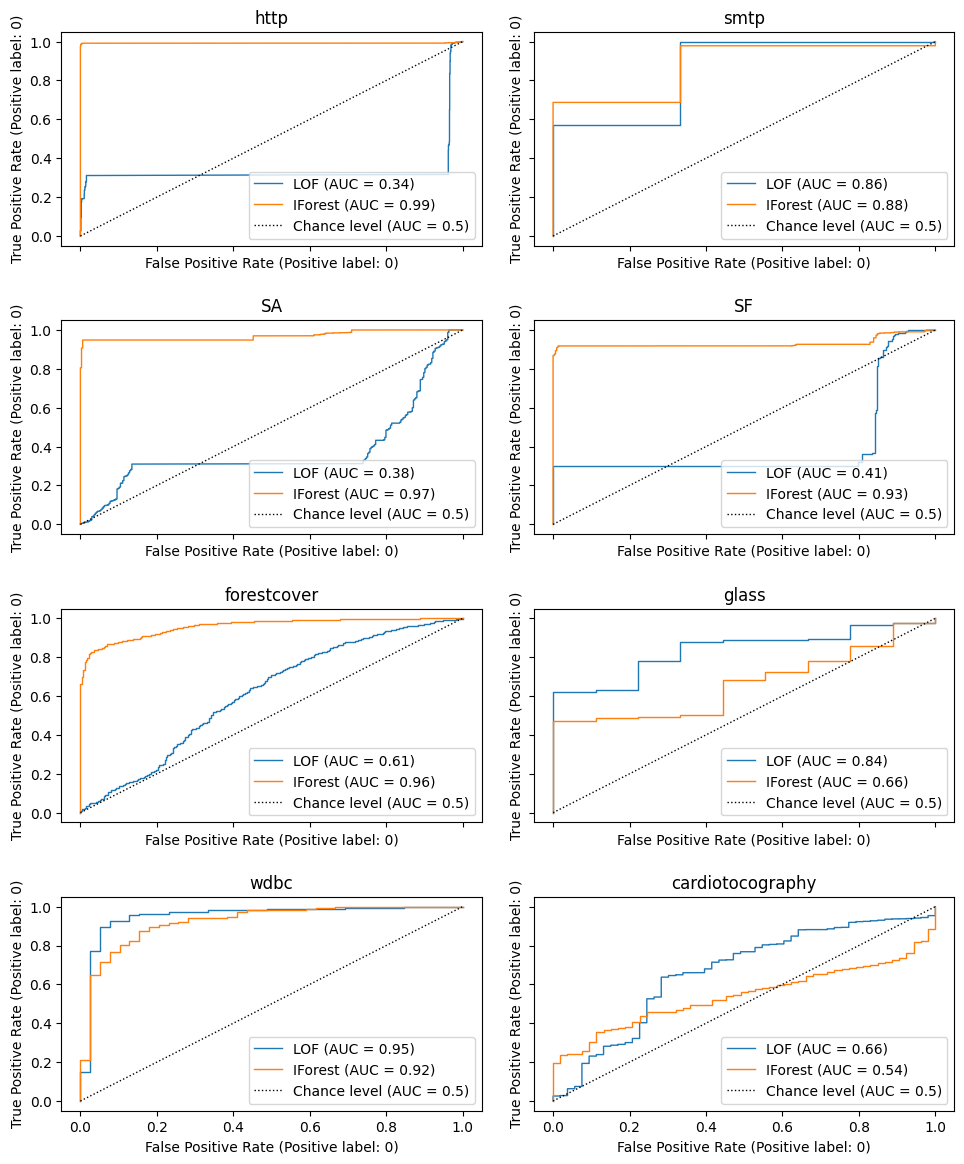

In [5]:
import math

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

datasets_name = [
    "http",
    "smtp",
    "SA",
    "SF",
    "forestcover",
    "glass",
    "wdbc",
    "cardiotocography",
]

models_name = [
    "LOF",
    "IForest",
]

# plotting parameters
cols = 2
linewidth = 1
pos_label = 0  # mean 0 belongs to positive class
rows = math.ceil(len(datasets_name) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3), sharex=True, sharey=True)

for i, dataset_name in enumerate(datasets_name):
    (X, y) = preprocess_dataset(dataset_name=dataset_name)

    for model_idx, model_name in enumerate(models_name):
        y_pred = compute_prediction(X, model_name=model_name)
        display = RocCurveDisplay.from_predictions(
            y,
            y_pred,
            pos_label=pos_label,
            name=model_name,
            linewidth=linewidth,
            ax=axs[i // cols, i % cols],
            plot_chance_level=(model_idx == len(models_name) - 1),
            chance_level_kw={
                "linewidth": linewidth,
                "linestyle": ":",
            },
        )
    axs[i // cols, i % cols].set_title(dataset_name)
plt.tight_layout(pad=2.0)  # spacing between subplots
plt.show()